In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, filtfilt
import pywt
import numpy as np
from statsmodels.robust import mad

In [2]:
plt.rcParams['axes.titlesize'] = 30

In [5]:
def read_signals(data_dir, channel):
    sigs = []
    titles = []
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        titles.append(file.split("/")[-1])
        
        with open(file_path, "r") as f:
            lines = f.readlines()
            signal = []
            for i, l in enumerate(lines):
                try:
                    reading = int(l.split(',')[channel+1])
                    if(reading < 1023):
                        signal.append(reading)
                except:
                    pass
            sigs.append(np.array(signal))
    return sigs, titles


def visualize_sigs(signals, titles, figsize=(20, 10)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()
    
def overlay_sigs(sigs_raw, sigs_proc, sub_titles, figtitle, labels, figsize=(20, 10)):
    n_sigs = len(sigs_raw)
    fig, ax = plt.subplots(n_sigs, figsize=figsize)
    for i in range(n_sigs): 
        ax[i].plot(sigs_raw[i], color="r", label=labels[0])
        ax[i].plot(sigs_proc[i], color="b", label=labels[1])
        ax[i].set_title(sub_titles[i])
        ax[i].legend()
    fig.suptitle(figtitle)
    plt.tight_layout()

def denoise_TKEO(signal):
    tkeo_sig = (np.square(signal[1:-1]) - signal[:-2] * signal[2:])
    return tkeo_sig

def get_baseline(signal, k=3, t=5, fs=1000):
    baseline_end = t * fs
    mean = np.mean(signal[:baseline_end])
    return mean

def get_threshold(signal, k, t=5, fs=1000):
    baseline_end = t * fs
    mean = np.mean(signal[:baseline_end])
    std = np.std(signal[:baseline_end])
    thresh = mean + std*k
    return thresh

def get_thresholds_2_channels(ch1, ch2, k=1):
    ch1_thresh = get_threshold(ch1, k)
    ch2_thresh = get_threshold(ch2, k)
    if(ch1_thresh > ch2_thresh):
        thresh2 = get_threshold(ch1, 0)
    else:
        thresh2 = get_threshold(ch2, 0)
    return max(ch1_thresh, ch2_thresh), thresh2

def remove_baseline(signal, mean):
    return signal - mean

def binarize_signal(signal, thresh):
    return signal > thresh

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y
    
def notch_filter(data, f=50, Q=30, fs=1000):
    b, a = iirnotch(f, Q, fs)
    y = filtfilt(b, a, data)
    return y

def dwt_smooth( x, wavelet="db4", level=None, smoothing_level=1, title=None ):
    '''
    adapted from http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    '''
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    sigma = mad( coeff[-smoothing_level] )
    thresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = [pywt.threshold( i, value=thresh, mode="soft" ) for i in coeff[1:]]
    return pywt.waverec(coeff, wavelet, mode="per")

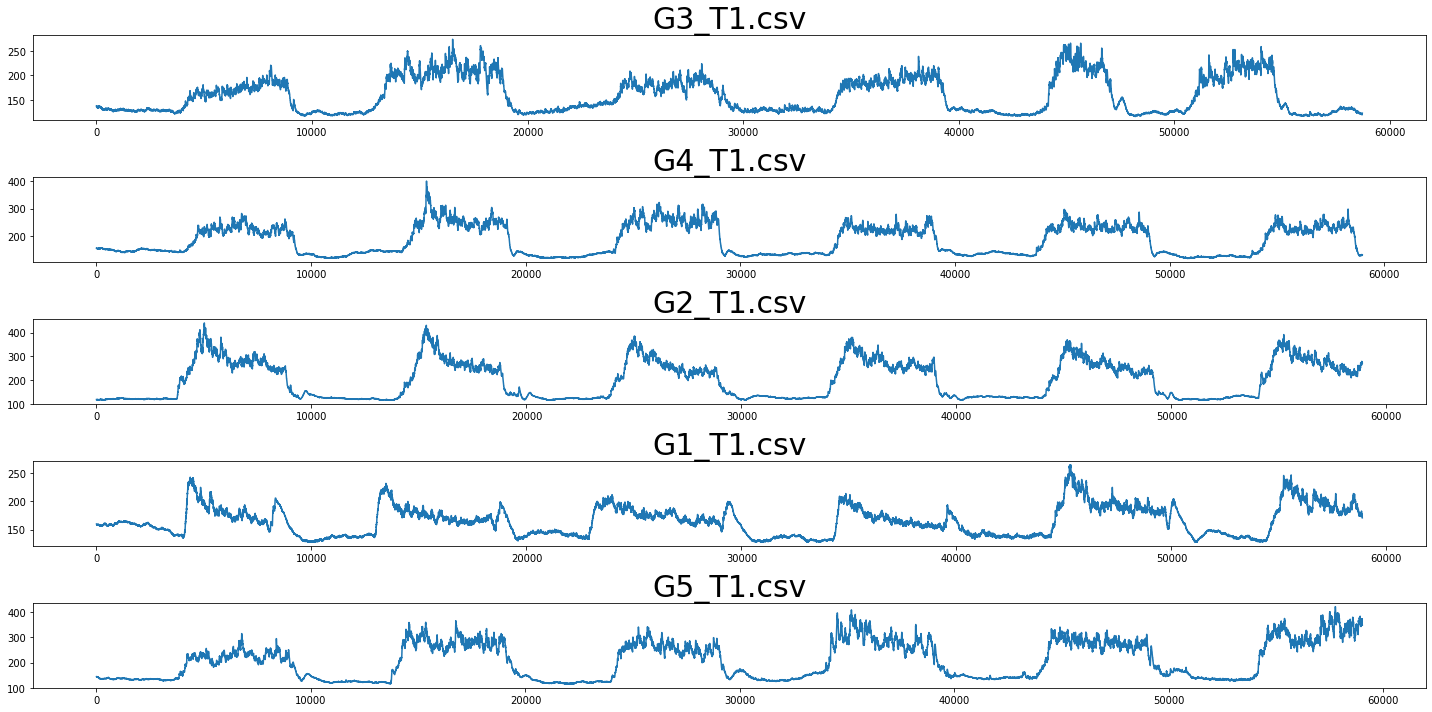

In [22]:
sigs, titles = read_signals("/home/amr/uni/graduation-proj/data-acq/collected-samples/lobna-signals", 0)
visualize_sigs(sigs, titles)

# Filtering
Filter signals using 4th order butterworth bandpass filter between 20-450Hz and a notch filter at 50hz

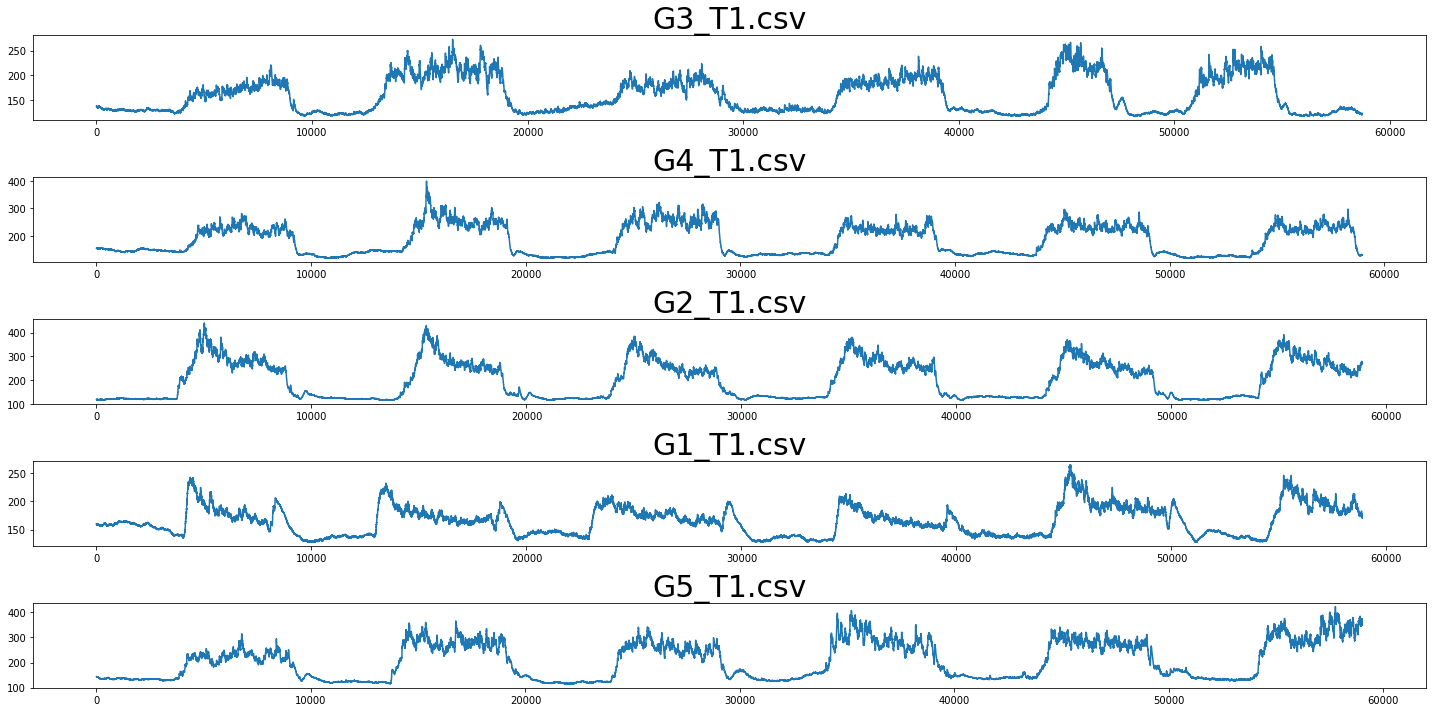

In [23]:
filtered_sigs = [butter_bandpass_filter(sig) for sig in sigs]
filtered_sigs = [notch_filter(sig) for sig in sigs]

visualize_sigs(filtered_sigs, titles)

# Baseline Removal
To remove noise, we take the average of the first 5s (resting period) as our baseline, and subtract it from our signal

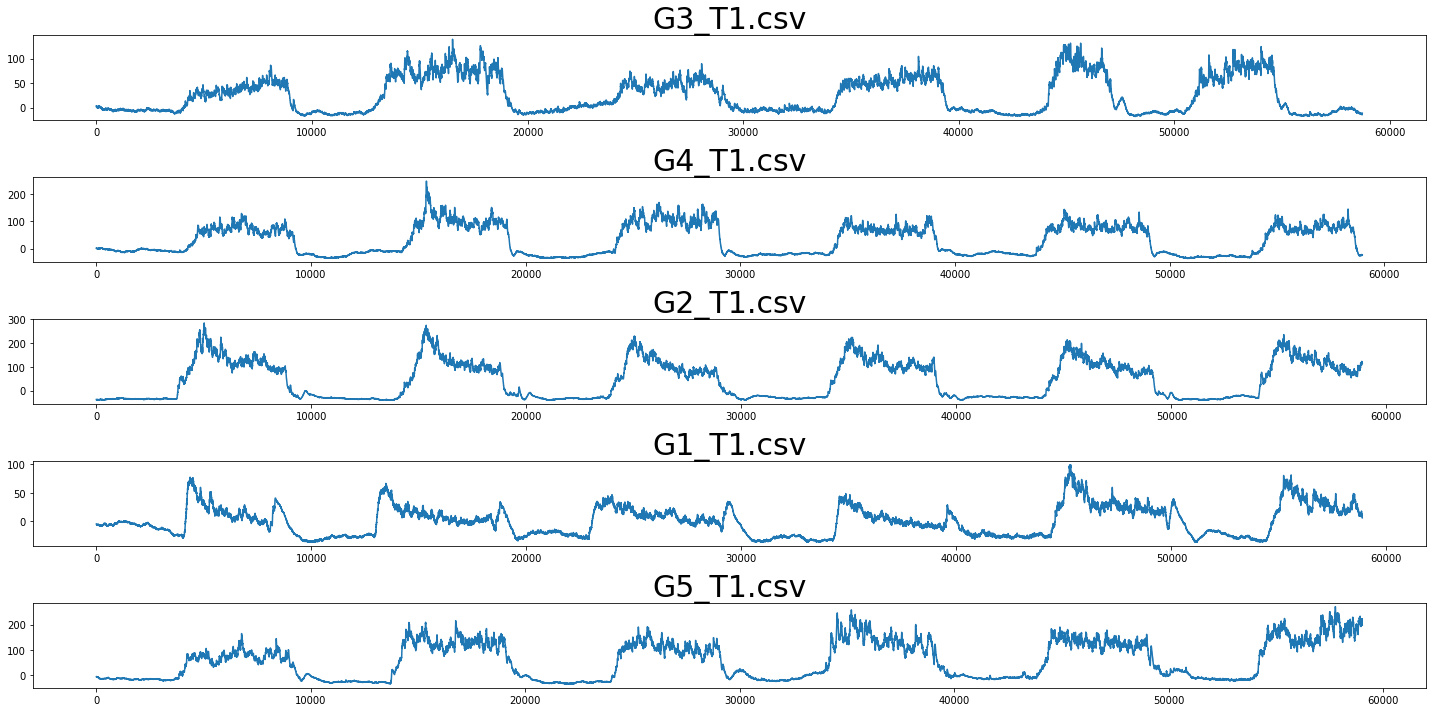

In [24]:
baselines = [get_baseline(sig) for sig in filtered_sigs]
baseline_removed_sigs = [remove_baseline(sig, bl) for sig, bl in zip(sigs, baselines)]

visualize_sigs(baseline_removed_sigs, titles)

# Thresholding
For data labeling, we get 2 thresholds. If we exceed the first (signal mean + std), we mark the beginning of gesture. If we then go below the second (signal mean), we mark the end of the gesture.

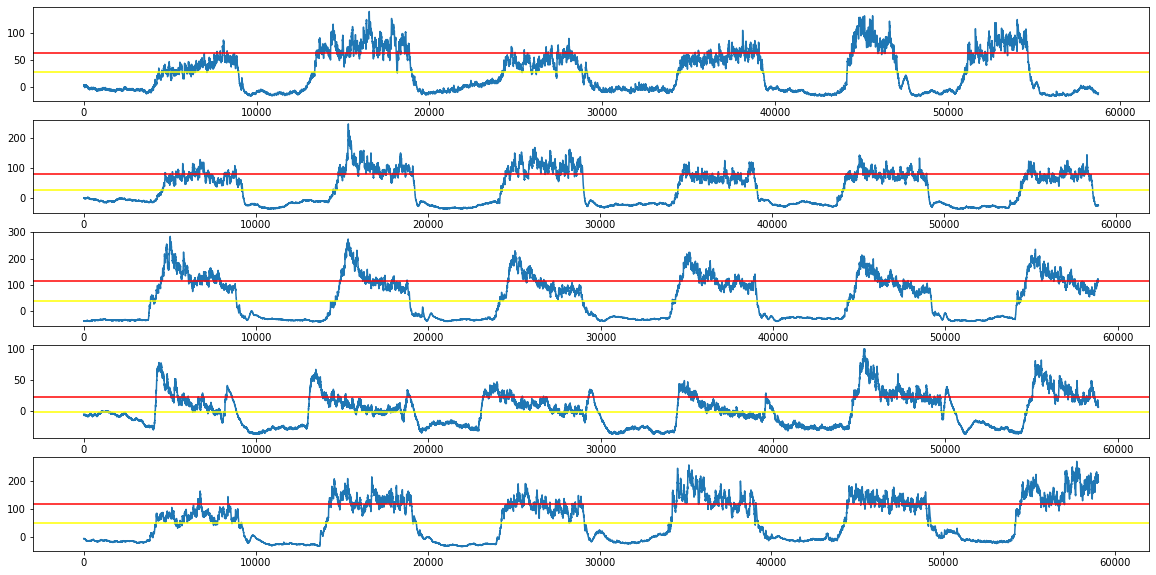

In [25]:
thresh_1 = [get_threshold(s, k=1, t=55) for s in baseline_removed_sigs]
thresh_2 = [get_threshold(s, k=0, t=55) for s in baseline_removed_sigs]

fig, ax = plt.subplots(5, 1, figsize = (20,10))

for i in range(5):
    ax[i].plot(baseline_removed_sigs[i])
    ax[i].axhline(thresh_1[i], color='red')
    ax[i].axhline(thresh_2[i], color='yellow')

# TKEO  

We can see above that some activity regions are below the threshold. As an alternative, we use TKEO operator which is defined as:
$$
TKEO[x(n)] = x^2(n) - x(n-1)*x(n+1)
$$

As recommended in [2] for thresholding, we follow the following procedure:
1. bandpass filter 30-300 Hz
2. TKEO
3. Rectification
4. Lowpass at 50 Hz
5. Threshold

[2] Teager–Kaiser energy operator signal conditioning improves EMG onset detection


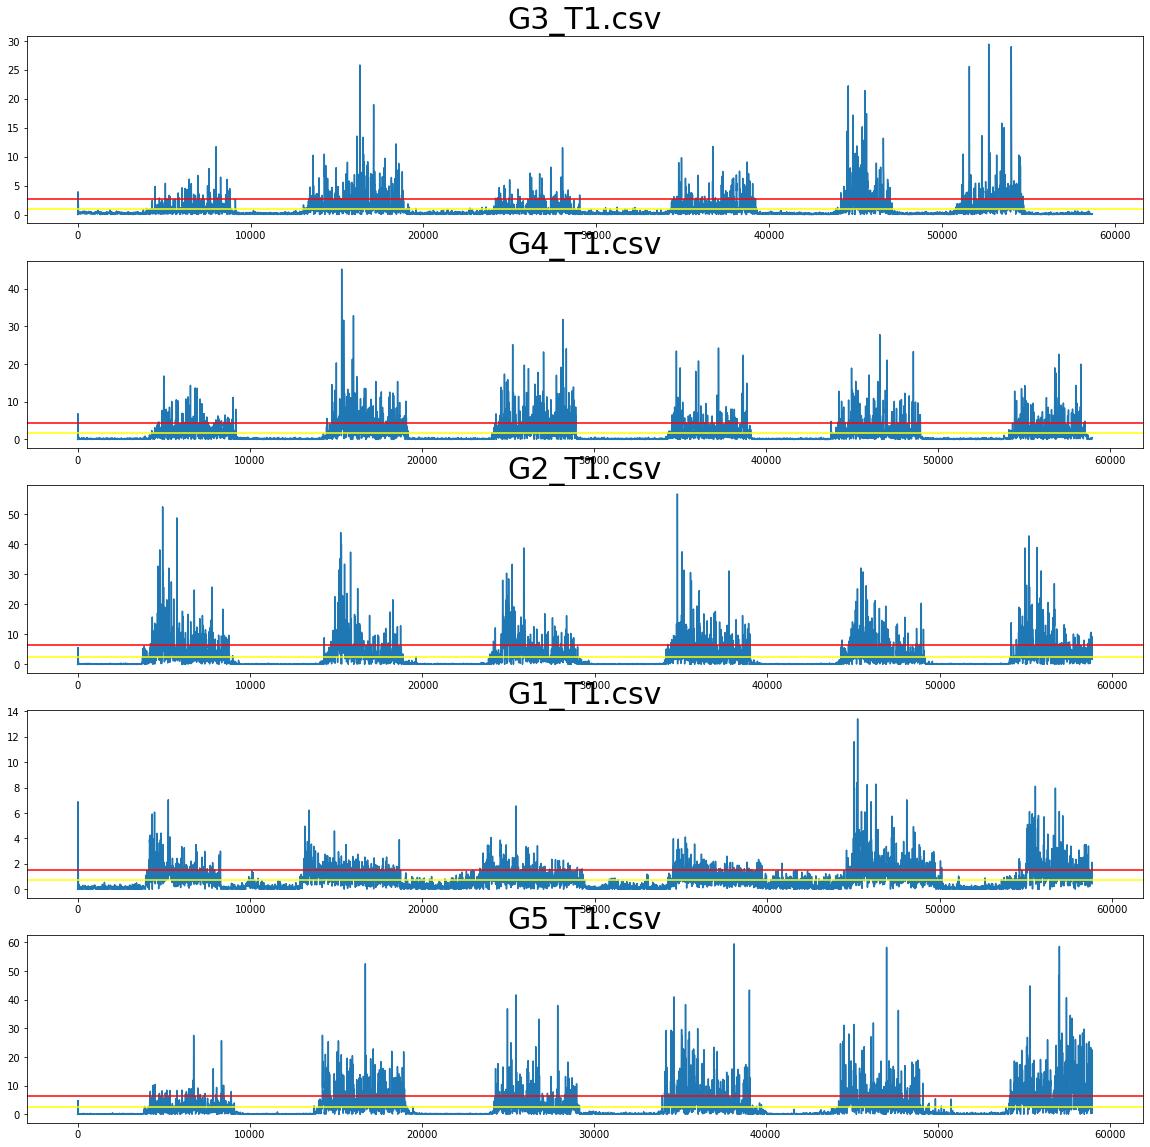

In [42]:
filt = [butter_bandpass_filter(sig, 30, 300) for sig in sigs]
filt = [sig[30:] for sig in filt]

tkeo_sigs = [np.abs(denoise_TKEO(sig)) for sig in filt]
tkeo_sigs = [butter_lowpass_filter(sig, 50, 1000, order=5) for sig in tkeo_sigs]

thresh_1 = [get_threshold(np.abs(s), k=1, t=55) for s in tkeo_sigs]
thresh_2 = [get_threshold(np.abs(s), k=0, t=55) for s in tkeo_sigs]

fig, ax = plt.subplots(5, 1, figsize = (20,20))
for i in range(5):
    ax[i].plot(np.abs(tkeo_sigs[i]))
    ax[i].axhline(thresh_1[i], color='red')
    ax[i].axhline(thresh_2[i], color='yellow')
    ax[i].set_title(titles[i])


# Frequency transformation

Text(0.5, 1.0, 'FFT in Frequency Domain')

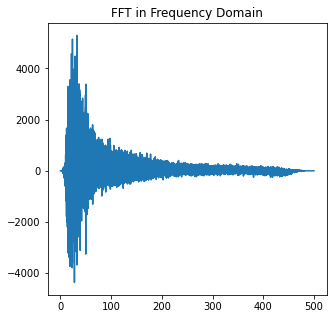

In [22]:
n = len(sigs[0])
fft_wave = np.fft.fft(butter_bandpass_filter(sigs[0]))

fft_fre = np.fft.fftfreq(n=fft_wave.size, d=1/1000)

plt.figure(figsize=(5, 5))
plt.subplot(111)
plt.plot(fft_fre[:fft_fre.size//2], fft_wave.real[:fft_wave.real.size//2])
plt.title("FFT in Frequency Domain")

# Power spectrum plot
We can plot the power spectrum of our signal after the bandpass filter, and we can see a strange peak at 50hz. This could be indicative of powerline intereference, so it might be appropriate to use a notch filter at 50hz to remove this

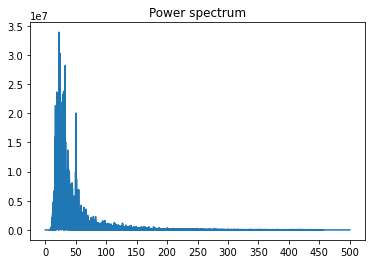

In [14]:
fs = 1000

time = np.arange(len(sigs[0])) / fs
freqs = np.fft.fftfreq(time.size, 1/fs)
idx = np.argsort(freqs)

ps = np.abs(np.fft.fft(butter_bandpass_filter(sigs[0])))**2
plt.figure()
plt.plot(freqs[:freqs.size//2], ps[:ps.size//2])
plt.xticks(np.arange(0, 550, 50))
plt.title('Power spectrum')

# Notch Filter
We use a notch filter at 50hz, and plot again the power spectrum. Now, the peak at 50hz disappears.

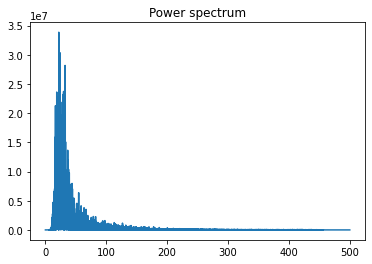

In [15]:
fs = 1000

time = np.arange(len(sigs[0])) / fs
freqs = np.fft.fftfreq(time.size, 1/fs)
idx = np.argsort(freqs)

ps = np.abs(np.fft.fft(notch_filter(butter_bandpass_filter(sigs[0]))))**2
plt.figure()
plt.plot(freqs[:freqs.size//2], ps[:ps.size//2])
plt.title('Power spectrum')

# Denoising using DWT
Another approach to get smoother EMG signal is using discrete wavelet transfrom. According to [1], the common wavelets used in denoising EMG signals are db2, db6, db8 and Meyer. We need to also experiment with different smoothing levels, and different ways to get thresholds

[1] Sobahi, Nebras. (2011). Denoising of EMG Signals Based on Wavelet Transform. Asian Transactions on Engineering. 1. 

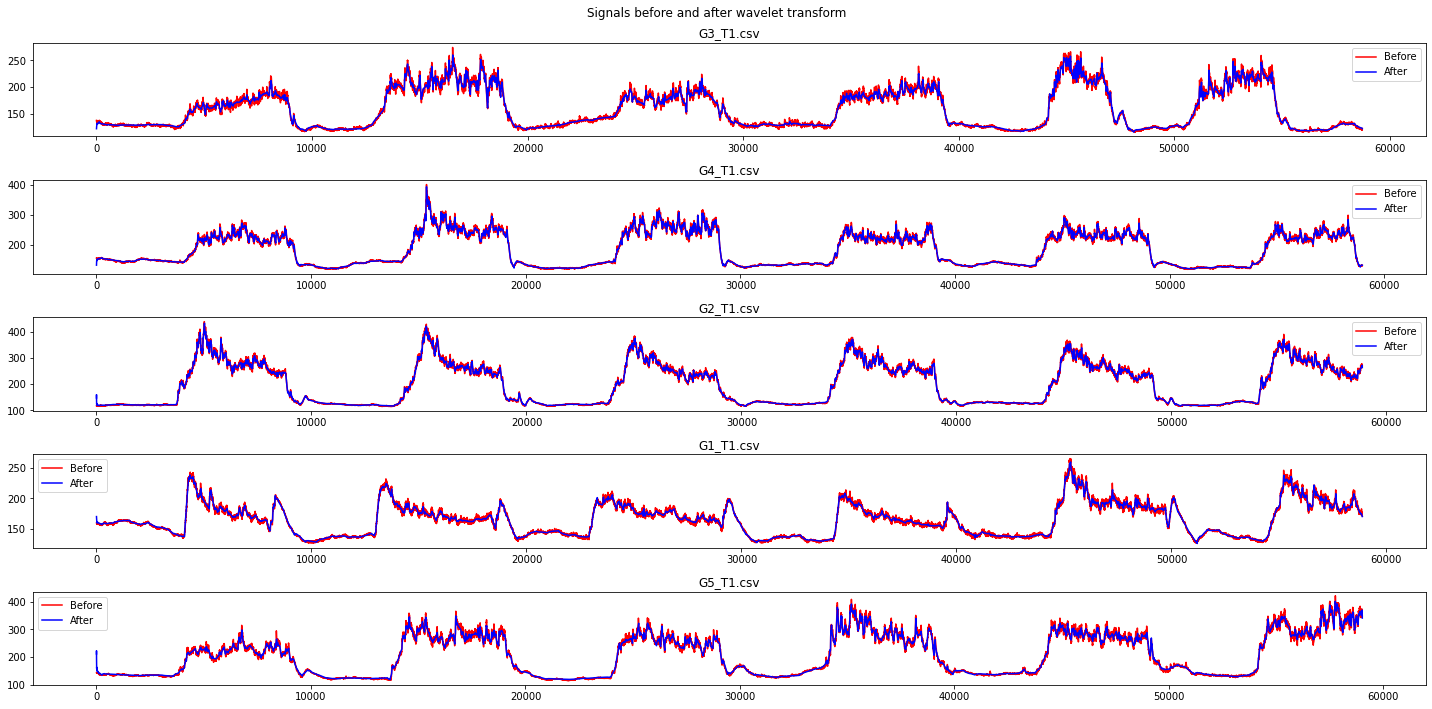

In [31]:
smooth_sigs = [dwt_smooth(sig, wavelet='db2', smoothing_level=5) for sig in sigs]
overlay_sigs(sigs, smooth_sigs, titles, "Signals before and after wavelet transform", 
             labels=["Before", "After"])

# 2-Channel Signals

Thresholding 2-channel signals is more challenging. Before, we used signal mean + std to determine beginning of muscular activity, and signal mean to determine the end. Now that we have two channels, we have 2 means and 2 standard deviations. It may make more sense to choose the higher mean, since there are some gestures that are associated with a single muscle and therefore it is very likely that this associated muscle will have higher amplitude. However, if a gesture is associated with 2 muscles, this doesn't work well.

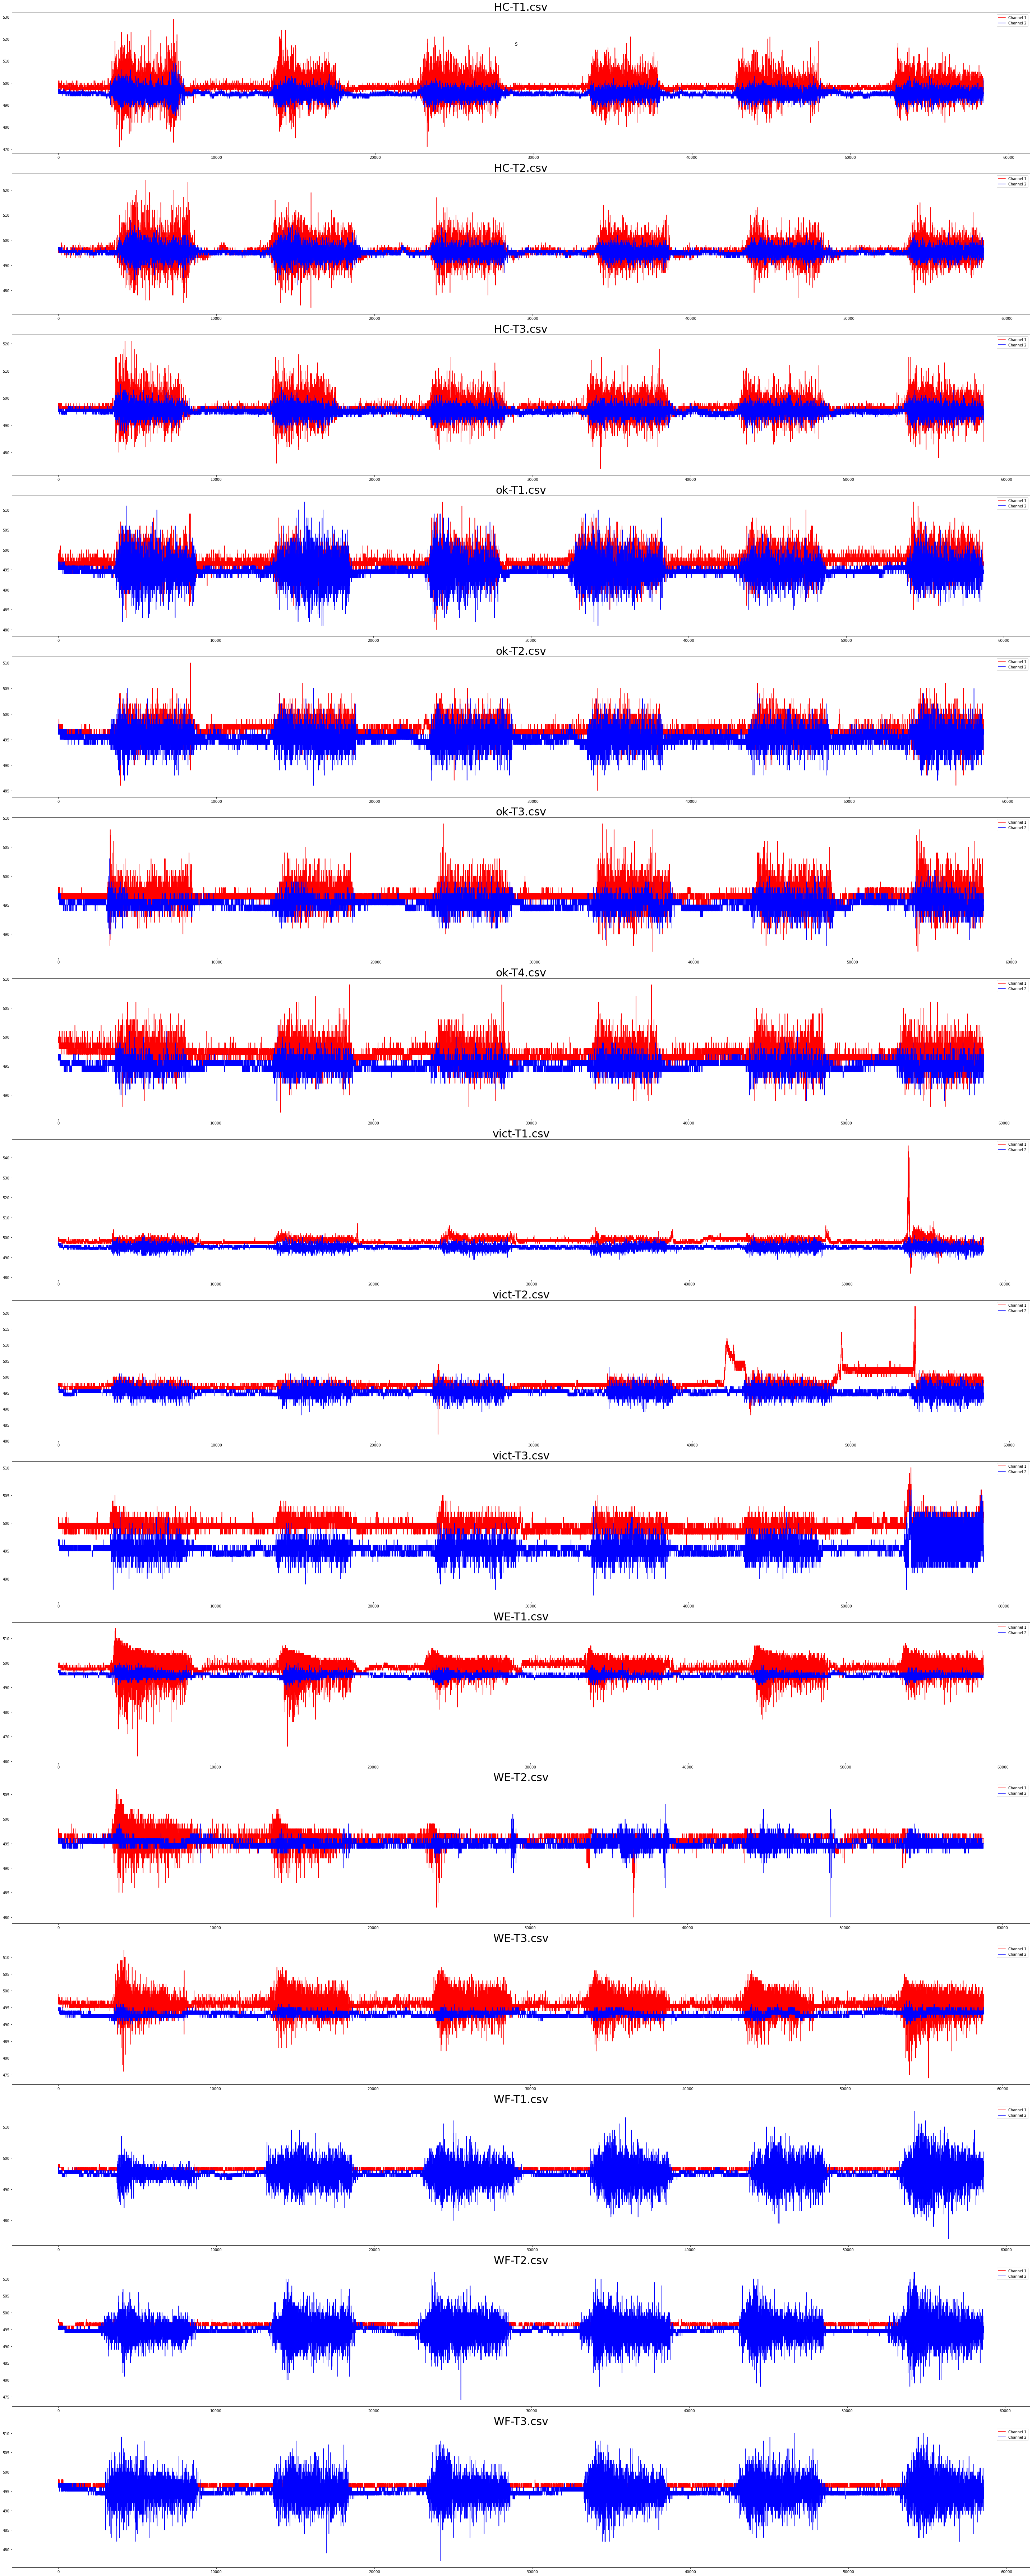

In [7]:
ch1_sigs, titles = read_signals(r"C:\Users\Hagar\Desktop\Biosignal-Analysis-for-VR-Based-Therapy\notebooks\raw\Hagar", 0)
ch2_sigs, titles = read_signals(r"C:\Users\Hagar\Desktop\Biosignal-Analysis-for-VR-Based-Therapy\notebooks\raw\Hagar", 1)

overlay_sigs(ch1_sigs, ch2_sigs, titles, "S", labels=["Channel 1", "Channel 2"], 
             figsize=(40,100))

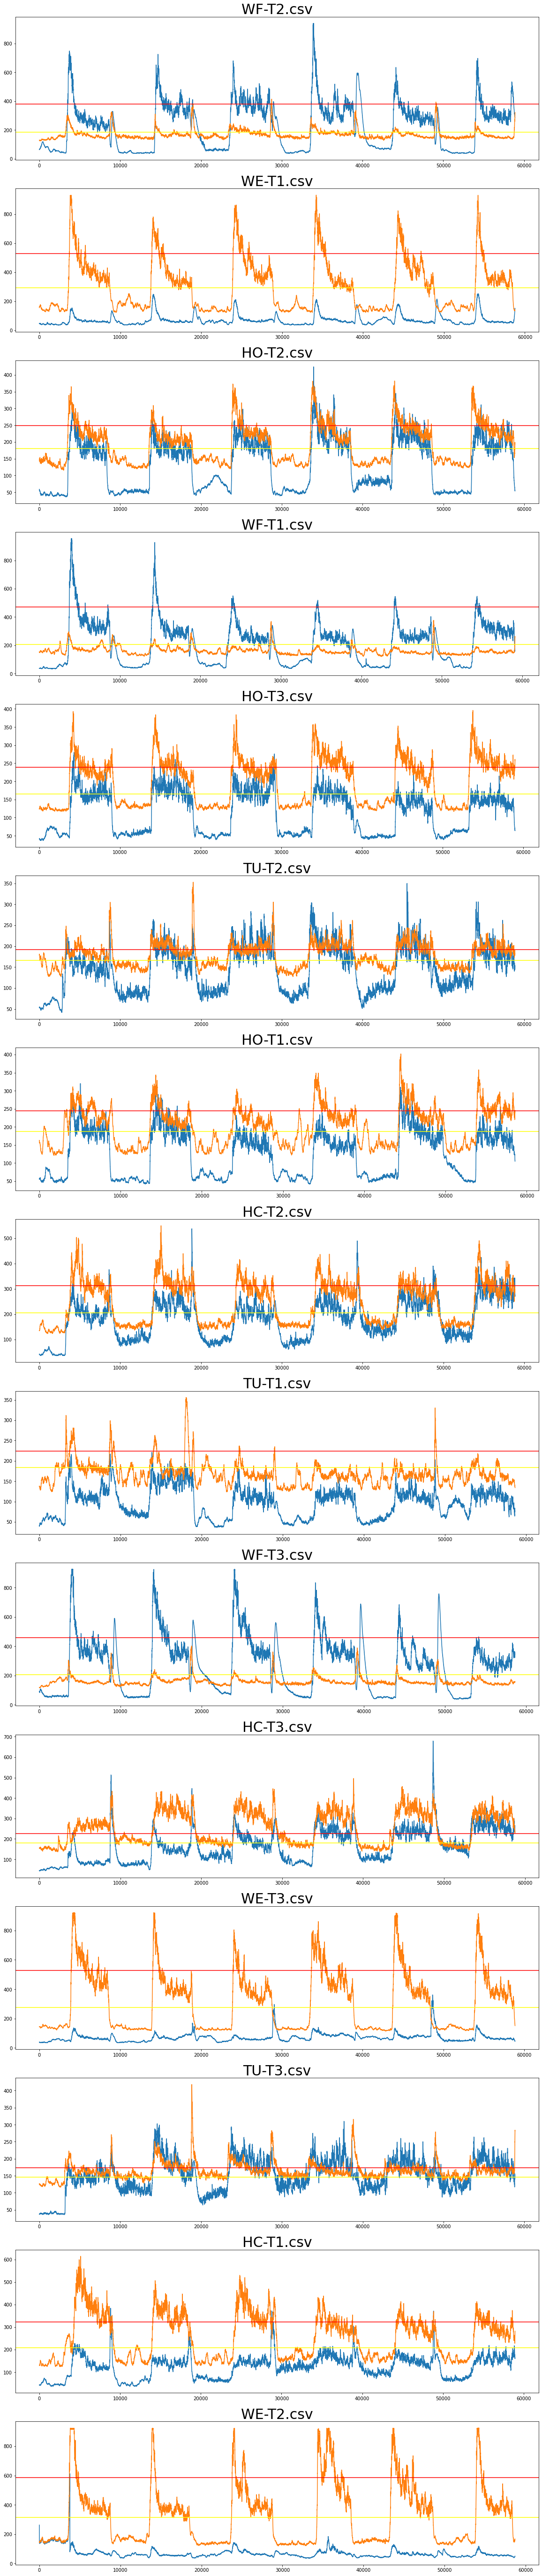

In [47]:
thresholds = [get_thresholds_2_channels(s1, s2, k=1) for s1, s2 in zip(ch1_sigs, ch2_sigs)]

n_plots = len(ch1_sigs)
fig, ax = plt.subplots(n_plots, 1, figsize = (20,100))
for i in range(n_plots):
    ax[i].plot(ch1_sigs[i])
    ax[i].plot(ch2_sigs[i])
    ax[i].axhline(thresholds[i][0], color='red')
    ax[i].axhline(thresholds[i][1], color='yellow')
    ax[i].set_title(titles[i])

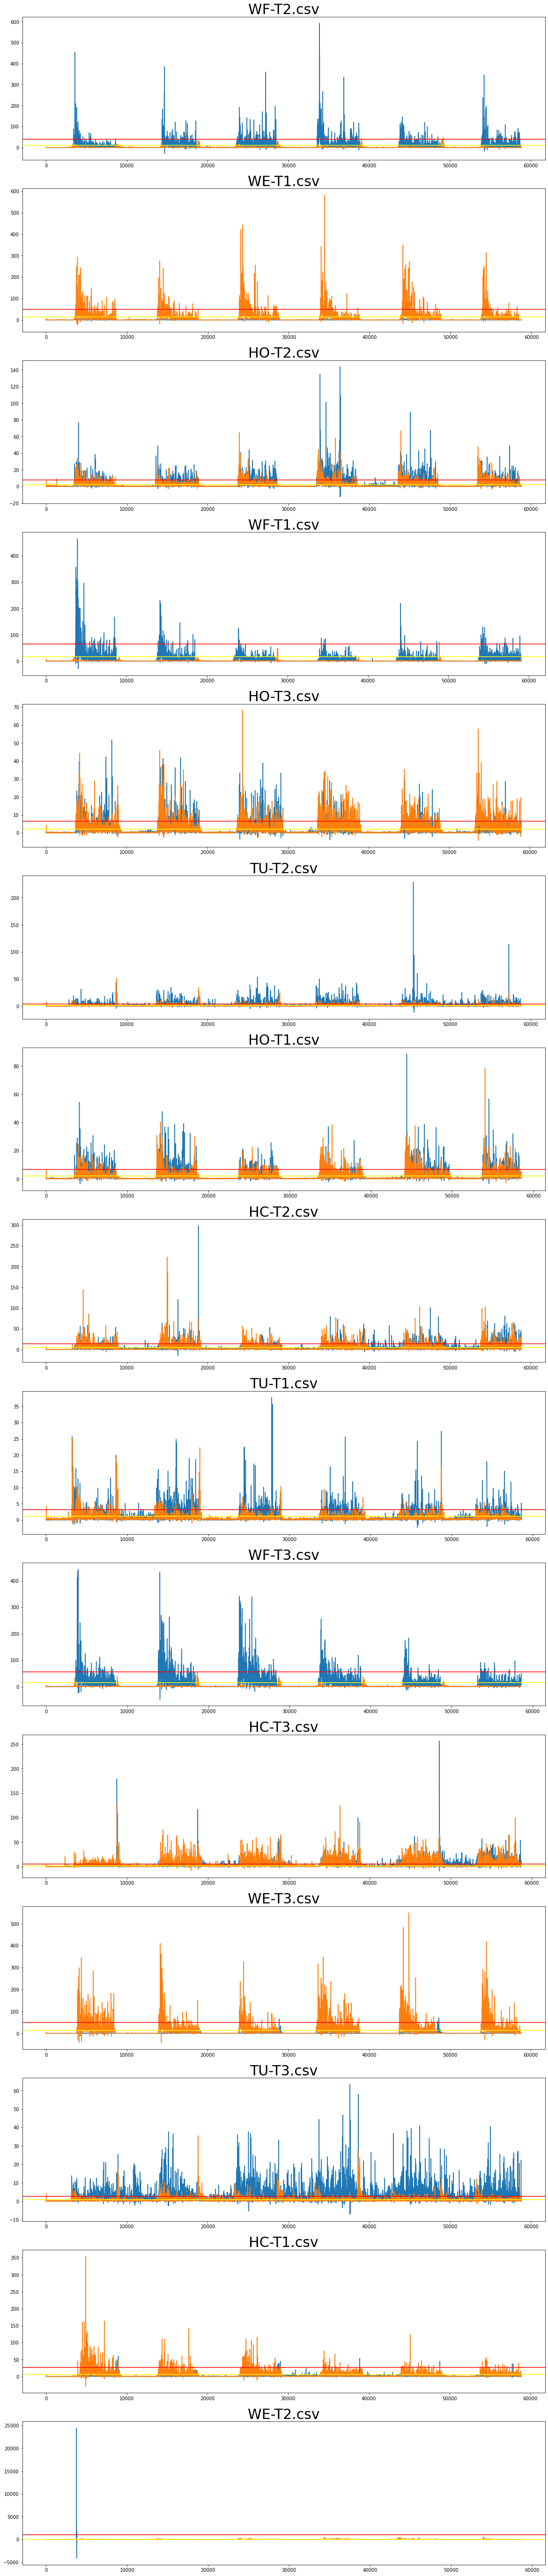

In [46]:
ch1_filt = [butter_bandpass_filter(sig, 30, 300) for sig in ch1_sigs]
ch2_filt = [butter_bandpass_filter(sig, 30, 300) for sig in ch2_sigs]

ch1_filt = [sig[30:] for sig in ch1_filt]
ch2_filt = [sig[30:] for sig in ch2_filt]

ch1_tkeo = [np.abs(denoise_TKEO(sig)) for sig in ch1_filt]
ch2_tkeo = [np.abs(denoise_TKEO(sig)) for sig in ch2_filt]

ch1_tkeo = [butter_lowpass_filter(sig, 50, 1000, order=5) for sig in ch1_tkeo]
ch2_tkeo = [butter_lowpass_filter(sig, 50, 1000, order=5) for sig in ch2_tkeo]

thresholds = [get_thresholds_2_channels(s1, s2, k=1) for s1, s2 in zip(ch1_tkeo, ch2_tkeo)]

n_plots = len(ch1_tkeo)
fig, ax = plt.subplots(n_plots, 1, figsize = (20,100))
for i in range(n_plots):
    ax[i].plot(ch1_tkeo[i])
    ax[i].plot(ch2_tkeo[i])
    ax[i].axhline(thresholds[i][0], color='red')
    ax[i].axhline(thresholds[i][1], color='yellow')
    ax[i].set_title(titles[i])